In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboost"
device = "cpu"
min_samples_per_class = 5
n_classes = 34
n_frac = 0.01
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Backdoor_Malware': 28,
    'BenignTraffic': 12,
    'BrowserHijacking': 29,
    'CommandInjection': 25,
    'DDoS-ACK_Fragmentation': 14,
    'DDoS-HTTP_Flood': 23,
    'DDoS-ICMP_Flood': 2,
    'DDoS-ICMP_Fragmentation': 17,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-RSTFINFlood': 0,
    'DDoS-SYN_Flood': 8,
    'DDoS-SlowLoris': 27,
    'DDoS-SynonymousIP_Flood': 6,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'DDoS-UDP_Fragmentation': 20,
    'DNS_Spoofing': 19,
    'DictionaryBruteForce': 30,
    'DoS-HTTP_Flood': 16,
    'DoS-SYN_Flood': 4,
    'DoS-TCP_Flood': 1,
    'DoS-UDP_Flood': 3,
    'MITM-ArpSpoofing': 13,
    'Mirai-greeth_flood': 5,
    'Mirai-greip_flood': 15,
    'Mirai-udpplain': 7,
    'Recon-HostDiscovery': 24,
    'Recon-OSScan': 21,
    'Recon-PingSweep': 32,
    'Recon-PortScan': 18,
    'SqlInjection': 31,
    'Uploading_Attack': 33,
    'VulnerabilityScan': 26,
    'XSS': 22}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
2     71563
11    54276
10    44924
9     40970
0     40615
8     40406
6     35893
3     33146
1     27077
4     20332
12    10978
5      9930
7      8965
15     7393
17     4537
13     3166
14     2880
20     2822
19     1824
24     1293
21     1011
18      833
16      750
26      376
23      275
27      236
30      128
29       58
25       49
31       43
22       42
28       36
32       23
33       16
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_2316080/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
2     72005
11    54122
10    44976
9     40947
8     40591
0     40452
6     35981
3     33185
1     26714
4     20288
12    10981
5      9918
7      8905
15     7516
17     4524
13     3075
20     2869
14     2851
19     1789
24     1343
21      982
18      822
16      718
26      373
23      287
27      234
30      130
29       58
25       54
31       52
22       38
28       32
32       22
33       12
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(466846, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max 

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(466846,)
int64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
34


label
2     72005
11    54122
10    44976
9     40947
8     40591
0     40452
6     35981
3     33185
1     26714
4     20288
12    10981
5      9918
7      8905
15     7516
17     4524
13     3075
20     2869
14     2851
19     1789
24     1343
21      982
18      822
16      718
26      373
23      287
27      234
30      130
29       58
25       54
31       52
22       38
28       32
32       22
33       12
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 280107	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Validation : 93369	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 93370	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-12 20:45:07,492] A new study created in memory with name: no-name-92acf86d-481a-4eb4-8f40-8347896f4621


[I 2024-07-12 20:56:41,748] Trial 0 finished with value: 0.7205153465349694 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.7205153465349694.


[I 2024-07-12 21:13:44,373] Trial 1 finished with value: 0.714003355687503 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.7205153465349694.


[I 2024-07-12 21:14:40,360] Trial 2 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 21:23:29,125] Trial 3 finished with value: 0.7172001989746102 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.7205153465349694.


[I 2024-07-12 21:24:57,144] Trial 4 pruned. 


index 13 is out of bounds for axis 0 with size 12


[I 2024-07-12 21:30:09,571] Trial 5 finished with value: 0.7144011915993419 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.7205153465349694.


[I 2024-07-12 21:31:50,438] Trial 6 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 21:40:38,454] Trial 7 finished with value: 0.7217128925732489 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 7 with value: 0.7217128925732489.


[I 2024-07-12 21:42:06,909] Trial 8 pruned. 


index 19 is out of bounds for axis 0 with size 12


[I 2024-07-12 21:43:08,421] Trial 9 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 21:44:04,673] Trial 10 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 22:00:55,229] Trial 11 finished with value: 0.714003355687503 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 7 with value: 0.7217128925732489.


[I 2024-07-12 22:02:38,633] Trial 12 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 22:04:18,699] Trial 13 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 22:17:36,111] Trial 14 finished with value: 0.7471454926477845 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 14 with value: 0.7471454926477845.


[I 2024-07-12 22:27:49,318] Trial 15 finished with value: 0.7266179694970307 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 14 with value: 0.7471454926477845.


[I 2024-07-12 22:29:43,770] Trial 16 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 22:48:54,699] Trial 17 finished with value: 0.7493652275024204 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-12 22:50:36,000] Trial 18 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 23:07:34,610] Trial 19 finished with value: 0.712459618659305 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-12 23:09:03,645] Trial 20 pruned. 


index 19 is out of bounds for axis 0 with size 12


[I 2024-07-12 23:17:50,607] Trial 21 finished with value: 0.7217128925732489 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-12 23:18:47,063] Trial 22 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 23:29:04,349] Trial 23 finished with value: 0.7266179694970307 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-12 23:30:00,693] Trial 24 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 23:31:42,637] Trial 25 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-12 23:33:12,130] Trial 26 pruned. 


index 19 is out of bounds for axis 0 with size 12


[I 2024-07-12 23:49:56,013] Trial 27 finished with value: 0.7202343455395441 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-12 23:50:50,312] Trial 28 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-12 23:52:17,366] Trial 29 pruned. 


index 13 is out of bounds for axis 0 with size 12


[I 2024-07-13 00:01:18,399] Trial 30 finished with value: 0.7169886996228308 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-13 00:10:07,837] Trial 31 finished with value: 0.7217128925732489 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-13 00:11:46,609] Trial 32 pruned. 


index 12 is out of bounds for axis 0 with size 12


[I 2024-07-13 00:22:02,536] Trial 33 finished with value: 0.7487422912677114 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-13 00:38:50,274] Trial 34 finished with value: 0.714003355687503 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


[I 2024-07-13 00:49:02,884] Trial 35 finished with value: 0.7266179694970307 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 17 with value: 0.7493652275024204.


CPU times: user 10d 13h 14min 15s, sys: 4min 19s, total: 10d 13h 18min 34s
Wall time: 4h 3min 55s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.720515 2024-07-12 20:45:07.493428 2024-07-12 20:56:41.748718   
1        1  0.714003 2024-07-12 20:56:41.749829 2024-07-12 21:13:44.373468   
2        2       NaN 2024-07-12 21:13:44.374502 2024-07-12 21:14:40.360743   
3        3  0.717200 2024-07-12 21:14:40.361654 2024-07-12 21:23:29.125706   
4        4       NaN 2024-07-12 21:23:29.126459 2024-07-12 21:24:57.144237   
5        5  0.714401 2024-07-12 21:24:57.145117 2024-07-12 21:30:09.570859   
6        6       NaN 2024-07-12 21:30:09.571876 2024-07-12 21:31:50.438067   
7        7  0.721713 2024-07-12 21:31:50.438959 2024-07-12 21:40:38.454494   
8        8       NaN 2024-07-12 21:40:38.455074 2024-07-12 21:42:06.909860   
9        9       NaN 2024-07-12 21:42:06.910505 2024-07-12 21:43:08.421143   
10      10       NaN 2024-07-12 21:43:08.422111 2024-07-12 21:44:04.673013   
11      11  0.714003 2024-07-12 21:44:04.673914 2024-07-12 22:00:55.229686   
12      12       NaN 2024-07-12 22:00:55.230702 2024-07-12 22:02:38.632935   
13      13       NaN 2024-07-12 22:02:38.633825 2024-07-12 22:04:18.699544   
14      14  0.747145 2024-07-12 22:04:18.700212 2024-07-12 22:17:36.111499   
15      15  0.726618 2024-07-12 22:17:36.112409 2024-07-12 22:27:49.318304   
16      16       NaN 2024-07-12 22:27:49.319329 2024-07-12 22:29:43.770417   
17      17  0.749365 2024-07-12 22:29:43.771176 2024-07-12 22:48:54.699347   
18      18       NaN 2024-07-12 22:48:54.700261 2024-07-12 22:50:36.000836   
19      19  0.712460 2024-07-12 22:50:36.001541 2024-07-12 23:07:34.610427   
20      20       NaN 2024-07-12 23:07:34.611447 2024-07-12 23:09:03.645118   
21      21  0.721713 2024-07-12 23:09:03.646030 2024-07-12 23:17:50.607797   
22      22       NaN 2024-07-12 23:17:50.608661 2024-07-12 23:18:47.063765   
23      23  0.726618 2024-07-12 23:18:47.064494 2024-07-12 23:29:04.349263   
24      24       NaN 2024-07-12 23:29:04.350294 2024-07-12 23:30:00.693136   
25      25       NaN 2024-07-12 23:30:00.693768 2024-07-12 23:31:42.637885   
26      26       NaN 2024-07-12 23:31:42.638604 2024-07-12 23:33:12.130135   
27      27  0.720234 2024-07-12 23:33:12.131029 2024-07-12 23:49:56.012899   
28      28       NaN 2024-07-12 23:49:56.013933 2024-07-12 23:50:50.312610   
29      29       NaN 2024-07-12 23:50:50.313236 2024-07-12 23:52:17.366870   
30      30  0.716989 2024-07-12 23:52:17.367570 2024-07-13 00:01:18.399460   
31      31  0.721713 2024-07-13 00:01:18.400374 2024-07-13 00:10:07.836921   
32      32       NaN 2024-07-13 00:10:07.837949 2024-07-13 00:11:46.608930   
33      33  0.748742 2024-07-13 00:11:46.609700 2024-07-13 00:22:02.536246   
34      34  0.714003 2024-07-13 00:22:02.537107 2024-07-13 00:38:50.274023   
35      35  0.726618 2024-07-13 00:38:50.275056 2024-07-13 00:49:02.884327   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:11:34.255290           boruta  feature_importances   
1  0 days 00:17:02.623639              rfa  feature_importances   
2  0 days 00:00:55.986241           boruta     shap_importances   
3  0 days 00:08:48.764052              rfe  feature_importances   
4  0 days 00:01:28.017778              rfe     shap_importances   
5  0 days 00:05:12.425742           boruta  feature_importances   
6  0 days 00:01:40.866191              rfa     shap_importances   
7  0 days 00:08:48.015535              rfe  feature_importances   
8  0 days 00:01:28.454786              rfe     shap_importances   
9  0 days 00:01:01.510638           boruta     shap_importances   
10 0 days 00:00:56.250902           boruta     shap_importances   
11 0 days 00:16:50.555772              rfa  feature_importances   
12 0 days 00:01:43.402233              rfa     shap_importances   
13 0 days 00:01:40.065719              rfa     shap_importances   
14 0 days 00:13:17.411287           boruta  feature_importances   
15 0 days 00:10:13.205895           boruta  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-13 00:49:03,917] Param fs_metric unique value length is less than 2.


[W 2024-07-13 00:49:03,918] Param fs_metric unique value length is less than 2.


[W 2024-07-13 00:49:03,918] Param fs_metric unique value length is less than 2.


[W 2024-07-13 00:49:03,919] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-13 00:49:05,121] A new study created in memory with name: no-name-101044e7-1e79-4ea4-9419-19f6577575d7


[I 2024-07-13 00:49:14,652] Trial 0 finished with value: 0.7594825665925251 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 0 with value: 0.7594825665925251.


[I 2024-07-13 00:49:23,975] Trial 1 finished with value: 0.750203787144358 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 0 with value: 0.7594825665925251.


[I 2024-07-13 00:49:36,147] Trial 2 finished with value: 0.7579821289144736 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 0 with value: 0.7594825665925251.


[I 2024-07-13 00:49:50,796] Trial 3 finished with value: 0.7651351582979286 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 3 with value: 0.7651351582979286.


[I 2024-07-13 00:50:05,773] Trial 4 finished with value: 0.7648269784181998 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 3 with value: 0.7651351582979286.


[I 2024-07-13 00:50:17,715] Trial 5 finished with value: 0.7602166623001426 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 3 with value: 0.7651351582979286.


[I 2024-07-13 00:50:29,767] Trial 6 finished with value: 0.7613724519939276 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 3 with value: 0.7651351582979286.


[I 2024-07-13 00:50:41,220] Trial 7 finished with value: 0.7618231126141755 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 3 with value: 0.7651351582979286.


[I 2024-07-13 00:50:53,730] Trial 8 finished with value: 0.7697355052874104 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 8 with value: 0.7697355052874104.


[I 2024-07-13 00:51:05,444] Trial 9 finished with value: 0.7578403456357798 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 8 with value: 0.7697355052874104.


[I 2024-07-13 00:51:16,062] Trial 10 finished with value: 0.7787927226293098 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:51:29,970] Trial 11 finished with value: 0.7560745139997289 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:51:41,954] Trial 12 finished with value: 0.7621098030140364 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:51:51,711] Trial 13 finished with value: 0.7588795255061797 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:52:02,174] Trial 14 finished with value: 0.7601507099741186 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:52:15,024] Trial 15 finished with value: 0.7674135896151725 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:52:26,307] Trial 16 finished with value: 0.76643773640205 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 10 with value: 0.7787927226293098.


[I 2024-07-13 00:52:44,292] Trial 17 finished with value: 0.791950982670767 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:52:59,046] Trial 18 finished with value: 0.7661635552616549 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:53:09,891] Trial 19 finished with value: 0.7638450130474922 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:53:21,658] Trial 20 finished with value: 0.7677089572432383 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:53:32,221] Trial 21 finished with value: 0.7669410482371691 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:53:47,262] Trial 22 finished with value: 0.7589895100307469 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:54:01,338] Trial 23 finished with value: 0.7503227440395873 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:54:15,353] Trial 24 finished with value: 0.7632126315202192 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:54:26,951] Trial 25 finished with value: 0.7677089572432383 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:54:38,724] Trial 26 finished with value: 0.7744793348446543 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:54:50,784] Trial 27 finished with value: 0.7758333595745878 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:55:02,773] Trial 28 finished with value: 0.7611670068189321 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:55:14,190] Trial 29 finished with value: 0.7748055662476586 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:55:25,864] Trial 30 finished with value: 0.7635946377887043 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:55:37,734] Trial 31 finished with value: 0.7668746337062686 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:55:51,962] Trial 32 finished with value: 0.7787927226293098 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:56:03,774] Trial 33 finished with value: 0.7677089572432383 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:56:18,941] Trial 34 finished with value: 0.769780468376625 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:56:33,153] Trial 35 finished with value: 0.7521532655975044 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:56:44,447] Trial 36 finished with value: 0.7585441140678766 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:56:57,862] Trial 37 finished with value: 0.7550734461693935 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:57:12,621] Trial 38 finished with value: 0.7628485101664976 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:57:24,387] Trial 39 finished with value: 0.7635946377887043 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:57:36,128] Trial 40 finished with value: 0.7738865775619002 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:57:51,826] Trial 41 finished with value: 0.7425019641563273 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:58:03,391] Trial 42 finished with value: 0.76643773640205 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:58:15,350] Trial 43 finished with value: 0.7630157085383054 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 17 with value: 0.791950982670767.


[I 2024-07-13 00:58:31,965] Trial 44 finished with value: 0.8041868509153471 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:58:46,550] Trial 45 finished with value: 0.7731410740360068 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:58:58,000] Trial 46 finished with value: 0.76643773640205 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:59:11,414] Trial 47 finished with value: 0.7677291136845545 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:59:24,692] Trial 48 finished with value: 0.7676169300756595 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:59:39,891] Trial 49 finished with value: 0.768510931084727 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 00:59:54,074] Trial 50 finished with value: 0.7566422449796872 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:00:09,596] Trial 51 finished with value: 0.7636167643224283 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:00:21,140] Trial 52 finished with value: 0.7578403456357798 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:00:37,627] Trial 53 finished with value: 0.7993892738914831 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:00:53,325] Trial 54 finished with value: 0.7773291940781837 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:01:03,545] Trial 55 finished with value: 0.7620004453237804 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:01:16,836] Trial 56 finished with value: 0.7478859314551157 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:01:28,531] Trial 57 finished with value: 0.7674499432603279 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:01:40,926] Trial 58 finished with value: 0.7718167918204398 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:01:53,314] Trial 59 finished with value: 0.763650498466595 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:02:05,310] Trial 60 finished with value: 0.7682150211745771 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:02:18,050] Trial 61 finished with value: 0.7564823932163239 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:02:30,933] Trial 62 finished with value: 0.7612228680695146 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:02:43,083] Trial 63 finished with value: 0.7739179375713491 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:02:54,812] Trial 64 finished with value: 0.7661353000882194 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:03:06,294] Trial 65 finished with value: 0.7506947026447733 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:03:19,180] Trial 66 finished with value: 0.7585047336447377 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:03:32,401] Trial 67 finished with value: 0.7679123555850209 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:03:48,036] Trial 68 finished with value: 0.7687000204346416 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:03:58,804] Trial 69 finished with value: 0.762821684092093 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:04:13,569] Trial 70 finished with value: 0.7575746106189003 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:04:25,189] Trial 71 finished with value: 0.768878173958291 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:04:36,981] Trial 72 finished with value: 0.7612643136377302 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:04:50,032] Trial 73 finished with value: 0.7818314310945788 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:05:05,848] Trial 74 finished with value: 0.7527380259120436 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:05:16,946] Trial 75 finished with value: 0.767219395792172 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:05:28,492] Trial 76 finished with value: 0.7600932119109948 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:05:42,188] Trial 77 finished with value: 0.7710517001228057 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:05:52,756] Trial 78 finished with value: 0.7787927226293098 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:06:02,631] Trial 79 finished with value: 0.7588795255061797 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:06:17,068] Trial 80 finished with value: 0.7734069192928184 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:06:31,255] Trial 81 finished with value: 0.7555683239373213 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:06:43,077] Trial 82 finished with value: 0.7635946377887043 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:06:59,195] Trial 83 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:07:10,926] Trial 84 finished with value: 0.7764480544108897 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:07:21,828] Trial 85 finished with value: 0.7733935245150463 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:07:37,572] Trial 86 finished with value: 0.769213737054133 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:07:51,381] Trial 87 finished with value: 0.7664222856344948 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:08:04,303] Trial 88 finished with value: 0.764646625042578 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:08:17,691] Trial 89 finished with value: 0.7631643282653688 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:08:28,832] Trial 90 finished with value: 0.7688480749245303 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:08:40,078] Trial 91 finished with value: 0.7733935245150463 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:08:52,844] Trial 92 finished with value: 0.7543525922202757 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:09:04,765] Trial 93 finished with value: 0.7636873224490133 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:09:21,996] Trial 94 finished with value: 0.8011002989265269 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:09:33,650] Trial 95 finished with value: 0.7682280800779755 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:09:48,394] Trial 96 finished with value: 0.7800012431578196 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:10:00,669] Trial 97 finished with value: 0.7571775816400399 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:10:12,230] Trial 98 finished with value: 0.7662842693896577 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:10:25,167] Trial 99 finished with value: 0.7728261391678544 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:10:36,736] Trial 100 finished with value: 0.7695190173848863 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:10:53,191] Trial 101 finished with value: 0.7735850474340338 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:11:07,163] Trial 102 finished with value: 0.7586204675474364 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:11:19,286] Trial 103 finished with value: 0.7531358423663148 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:11:32,930] Trial 104 finished with value: 0.7658611242794171 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:11:46,203] Trial 105 finished with value: 0.7617896114784742 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:11:59,391] Trial 106 finished with value: 0.7663092699128855 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:12:10,461] Trial 107 finished with value: 0.7584978187287444 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:12:21,672] Trial 108 finished with value: 0.76643773640205 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:12:32,758] Trial 109 finished with value: 0.7618231126141755 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:12:46,031] Trial 110 finished with value: 0.752208557288858 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:12:57,680] Trial 111 finished with value: 0.7765169903137533 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:13:11,254] Trial 112 finished with value: 0.7688182869105323 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:13:24,804] Trial 113 finished with value: 0.7602859110652842 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:13:36,497] Trial 114 finished with value: 0.7578403456357798 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:13:48,314] Trial 115 finished with value: 0.7635946377887043 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:13:59,747] Trial 116 finished with value: 0.7578403456357798 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:14:12,027] Trial 117 finished with value: 0.7634985908457415 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:14:24,957] Trial 118 finished with value: 0.7626237094808523 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:14:36,761] Trial 119 finished with value: 0.7662842693896577 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:14:48,636] Trial 120 finished with value: 0.7700316761709062 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:15:04,668] Trial 121 finished with value: 0.7724931945463344 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:15:19,218] Trial 122 finished with value: 0.7524928800204994 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:15:29,237] Trial 123 finished with value: 0.762821684092093 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:15:42,896] Trial 124 finished with value: 0.7679241710947098 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:15:53,638] Trial 125 finished with value: 0.7627907157553648 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:16:05,927] Trial 126 finished with value: 0.7514519834109414 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:16:20,095] Trial 127 finished with value: 0.7573707527174054 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:16:32,230] Trial 128 finished with value: 0.758906640921079 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:16:46,337] Trial 129 finished with value: 0.7536927884091734 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:16:57,708] Trial 130 finished with value: 0.7748055662476586 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:17:09,530] Trial 131 finished with value: 0.7629273611237257 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:17:26,898] Trial 132 finished with value: 0.8010429045986356 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:17:37,568] Trial 133 finished with value: 0.7733935245150463 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:17:48,887] Trial 134 finished with value: 0.7749466790279478 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:18:01,424] Trial 135 finished with value: 0.762669521923255 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:18:12,355] Trial 136 finished with value: 0.7733935245150463 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:18:27,262] Trial 137 finished with value: 0.7656676285936238 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:18:42,962] Trial 138 finished with value: 0.7643063980867768 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:18:59,535] Trial 139 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:19:09,679] Trial 140 finished with value: 0.7647093092073938 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:19:24,050] Trial 141 finished with value: 0.7696807034133044 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:19:35,136] Trial 142 finished with value: 0.7691924990828746 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:19:45,619] Trial 143 finished with value: 0.7629783743394747 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:19:57,551] Trial 144 finished with value: 0.7610469803350116 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:20:12,223] Trial 145 finished with value: 0.7594736447834736 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:20:24,148] Trial 146 finished with value: 0.7697941109018906 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:20:36,097] Trial 147 finished with value: 0.7632823300130639 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:20:49,296] Trial 148 finished with value: 0.7772422466895603 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 44 with value: 0.8041868509153471.


[I 2024-07-13 01:21:08,094] Trial 149 finished with value: 0.8192828011373537 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:21:23,103] Trial 150 finished with value: 0.7734966385701547 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:21:32,607] Trial 151 finished with value: 0.7563076866062988 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:21:45,699] Trial 152 finished with value: 0.7642557760781292 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:21:57,075] Trial 153 finished with value: 0.7765169903137533 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:22:16,067] Trial 154 finished with value: 0.7973843093904868 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:22:27,074] Trial 155 finished with value: 0.7618231126141755 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:22:39,649] Trial 156 finished with value: 0.7773397829800636 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:22:55,840] Trial 157 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:23:08,165] Trial 158 finished with value: 0.7553691910409617 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:23:19,706] Trial 159 finished with value: 0.7662842693896577 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:23:29,551] Trial 160 finished with value: 0.7588795255061797 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:23:41,257] Trial 161 finished with value: 0.7543081709712257 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:24:00,416] Trial 162 finished with value: 0.7527329416599612 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:24:14,852] Trial 163 finished with value: 0.7493652275024204 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:24:27,149] Trial 164 finished with value: 0.7608092845323787 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:24:43,226] Trial 165 finished with value: 0.7744939956151787 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:24:53,293] Trial 166 finished with value: 0.7647093092073938 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:25:07,799] Trial 167 finished with value: 0.763728490091251 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:25:19,076] Trial 168 finished with value: 0.7668466676736028 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:25:32,045] Trial 169 finished with value: 0.7789581715251378 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:25:47,277] Trial 170 finished with value: 0.76602007735421 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:25:58,026] Trial 171 finished with value: 0.7690885746028993 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:26:09,636] Trial 172 finished with value: 0.7698974111255772 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:26:24,609] Trial 173 finished with value: 0.7652599848553748 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:26:34,723] Trial 174 finished with value: 0.7787927226293098 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:26:50,044] Trial 175 finished with value: 0.752143106065027 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:27:03,207] Trial 176 finished with value: 0.7532901238987398 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:27:16,434] Trial 177 finished with value: 0.7595581878860179 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:27:30,041] Trial 178 finished with value: 0.7696807199942979 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:27:41,380] Trial 179 finished with value: 0.7700932666766245 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:27:52,777] Trial 180 finished with value: 0.7727571474773144 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:28:02,628] Trial 181 finished with value: 0.7647093092073938 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:28:15,850] Trial 182 finished with value: 0.7717560286487528 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:28:27,395] Trial 183 finished with value: 0.7748055662476586 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:28:40,067] Trial 184 finished with value: 0.7566893475523816 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:28:50,271] Trial 185 finished with value: 0.7647093092073938 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:02,015] Trial 186 finished with value: 0.7635946377887043 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:13,614] Trial 187 finished with value: 0.7636873224490133 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:24,547] Trial 188 finished with value: 0.7576374415472399 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:37,905] Trial 189 finished with value: 0.7591416731541711 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:48,229] Trial 190 finished with value: 0.7647093092073938 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:29:59,530] Trial 191 finished with value: 0.7655894129283309 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:30:11,008] Trial 192 finished with value: 0.7765169903137533 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:30:22,232] Trial 193 finished with value: 0.7655894129283309 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:30:35,271] Trial 194 finished with value: 0.769480535095485 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:30:45,959] Trial 195 finished with value: 0.7787927226293098 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:30:57,324] Trial 196 finished with value: 0.7618231126141755 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:31:06,733] Trial 197 finished with value: 0.7681700390617092 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:31:18,214] Trial 198 finished with value: 0.7720643457590973 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:31:31,542] Trial 199 finished with value: 0.7665198456301825 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:31:50,211] Trial 200 finished with value: 0.8016277876155842 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:32:01,869] Trial 201 finished with value: 0.7556521749144199 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:32:16,763] Trial 202 finished with value: 0.7635023525207532 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:32:29,126] Trial 203 finished with value: 0.758339939277295 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:32:42,193] Trial 204 finished with value: 0.7742802526748552 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:32:53,239] Trial 205 finished with value: 0.767497050677211 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:33:02,685] Trial 206 finished with value: 0.7681700390617092 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:33:15,305] Trial 207 finished with value: 0.7695107940249248 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:33:28,811] Trial 208 finished with value: 0.7648943983118939 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:33:39,304] Trial 209 finished with value: 0.762821684092093 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:33:54,611] Trial 210 finished with value: 0.7596179543721927 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:34:05,565] Trial 211 finished with value: 0.7655894129283309 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:34:15,801] Trial 212 finished with value: 0.753670022517017 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:34:28,284] Trial 213 finished with value: 0.7638086107506193 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:34:41,846] Trial 214 finished with value: 0.7713615793565652 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:34:53,244] Trial 215 finished with value: 0.7644547468032588 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:35:03,951] Trial 216 finished with value: 0.7657665871480868 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:35:15,633] Trial 217 finished with value: 0.7661927441939775 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:35:28,132] Trial 218 finished with value: 0.7628566765449725 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:35:38,755] Trial 219 finished with value: 0.7576374415472399 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:35:50,600] Trial 220 finished with value: 0.7527809237084734 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:36:02,284] Trial 221 finished with value: 0.7778551592989884 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:36:17,080] Trial 222 finished with value: 0.770774711817838 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:36:29,845] Trial 223 finished with value: 0.7746997703237192 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:36:44,274] Trial 224 finished with value: 0.7659441538729377 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:36:56,786] Trial 225 finished with value: 0.7669423748301831 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:37:06,992] Trial 226 finished with value: 0.7620084602051274 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:37:19,532] Trial 227 finished with value: 0.7672249447637007 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:37:35,132] Trial 228 finished with value: 0.7662372463809334 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:37:49,368] Trial 229 finished with value: 0.7538466155456127 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:37:58,708] Trial 230 finished with value: 0.7556562395781377 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:38:09,966] Trial 231 finished with value: 0.7655323236571461 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:38:21,598] Trial 232 finished with value: 0.7837835201188601 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:38:37,176] Trial 233 finished with value: 0.7638621849767309 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:38:49,605] Trial 234 finished with value: 0.7471538491871607 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:39:01,376] Trial 235 finished with value: 0.7703004632283565 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:39:11,084] Trial 236 finished with value: 0.7715591956232819 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:39:30,132] Trial 237 finished with value: 0.7973224074087648 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:39:43,397] Trial 238 finished with value: 0.7631582243549592 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:39:56,231] Trial 239 finished with value: 0.7670719707126037 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:40:08,639] Trial 240 finished with value: 0.7612009155871977 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:40:19,422] Trial 241 finished with value: 0.7576374415472399 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:40:31,332] Trial 242 finished with value: 0.7618155229923247 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:40:44,823] Trial 243 finished with value: 0.7591530948323887 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:40:59,288] Trial 244 finished with value: 0.767579661740699 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:41:10,835] Trial 245 finished with value: 0.7578403456357798 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:41:30,625] Trial 246 finished with value: 0.8051050073442804 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:41:45,587] Trial 247 finished with value: 0.7697940396190774 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:41:58,216] Trial 248 finished with value: 0.7598858089933722 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:42:13,967] Trial 249 finished with value: 0.7676757060099372 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:42:29,530] Trial 250 finished with value: 0.7785432589316611 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:42:41,555] Trial 251 finished with value: 0.7636873224490133 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:42:53,727] Trial 252 finished with value: 0.7791627195432018 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:43:05,838] Trial 253 finished with value: 0.7728039966525108 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:43:16,533] Trial 254 finished with value: 0.7576374415472399 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:43:28,953] Trial 255 finished with value: 0.7636873224490133 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:43:42,911] Trial 256 finished with value: 0.7746295619071474 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:43:57,536] Trial 257 finished with value: 0.756990878377473 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:44:08,706] Trial 258 finished with value: 0.7618231126141755 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:44:22,797] Trial 259 finished with value: 0.7615881212782449 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:44:36,547] Trial 260 finished with value: 0.7692318815541244 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:44:47,980] Trial 261 finished with value: 0.771848641854139 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:45:02,469] Trial 262 finished with value: 0.7706643408025727 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:45:17,128] Trial 263 finished with value: 0.7643654676623066 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:45:29,134] Trial 264 finished with value: 0.7636873224490133 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:45:42,111] Trial 265 finished with value: 0.7660275876819354 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:45:54,299] Trial 266 finished with value: 0.7666504490000567 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:46:05,543] Trial 267 finished with value: 0.7655894129283309 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:46:19,488] Trial 268 finished with value: 0.7765115259488498 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:46:35,930] Trial 269 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:46:48,075] Trial 270 finished with value: 0.7715528799496456 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:46:59,531] Trial 271 finished with value: 0.7652590395033938 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:47:15,892] Trial 272 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:47:28,822] Trial 273 finished with value: 0.772693464981071 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:47:39,842] Trial 274 finished with value: 0.7684687311596541 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:47:51,586] Trial 275 finished with value: 0.7713536792108657 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:48:03,137] Trial 276 finished with value: 0.7655894129283309 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:48:19,183] Trial 277 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:48:32,020] Trial 278 finished with value: 0.7589826194363309 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:48:43,872] Trial 279 finished with value: 0.7626217846937674 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:48:53,244] Trial 280 finished with value: 0.7681700390617092 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:49:05,060] Trial 281 finished with value: 0.7660137132504526 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:49:16,964] Trial 282 finished with value: 0.7677089572432383 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:49:29,426] Trial 283 finished with value: 0.7688179673792624 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:49:43,329] Trial 284 finished with value: 0.7659113810307259 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:49:55,054] Trial 285 finished with value: 0.7568332468251623 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:50:06,614] Trial 286 finished with value: 0.7651949823694945 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:50:19,738] Trial 287 finished with value: 0.7670016588856197 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:50:33,616] Trial 288 finished with value: 0.7739084109624649 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:50:50,423] Trial 289 finished with value: 0.8041371896782984 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:51:04,016] Trial 290 finished with value: 0.7646247581172244 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:51:14,646] Trial 291 finished with value: 0.7558224933669289 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:51:27,617] Trial 292 finished with value: 0.779496224431349 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:51:39,158] Trial 293 finished with value: 0.7748055662476586 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:51:49,958] Trial 294 finished with value: 0.7625486712146086 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:52:03,473] Trial 295 finished with value: 0.7664758310068672 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:52:18,594] Trial 296 finished with value: 0.76313380760179 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:52:34,137] Trial 297 finished with value: 0.7586992119366675 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:52:44,064] Trial 298 finished with value: 0.7647629545869484 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:52:55,823] Trial 299 finished with value: 0.7765169903137533 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:53:07,476] Trial 300 finished with value: 0.7748055662476586 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:53:19,157] Trial 301 finished with value: 0.7662842693896577 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:53:31,290] Trial 302 finished with value: 0.7355934698504158 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:53:46,411] Trial 303 finished with value: 0.7603602692556576 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:53:58,322] Trial 304 finished with value: 0.7677089572432383 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:54:11,736] Trial 305 finished with value: 0.7685057447855682 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:54:26,863] Trial 306 finished with value: 0.7574739665758101 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:54:37,634] Trial 307 finished with value: 0.762821684092093 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:54:49,111] Trial 308 finished with value: 0.7767854217160348 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:54:58,788] Trial 309 finished with value: 0.7588795255061797 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:55:09,821] Trial 310 finished with value: 0.7700384354532972 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:55:24,129] Trial 311 finished with value: 0.7652194826501875 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:55:37,161] Trial 312 finished with value: 0.7536128341318907 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:55:49,912] Trial 313 finished with value: 0.7558312078114309 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:56:05,721] Trial 314 finished with value: 0.7662842693896577 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:56:16,835] Trial 315 finished with value: 0.7733935245150463 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:56:28,096] Trial 316 finished with value: 0.76643773640205 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:56:38,771] Trial 317 finished with value: 0.7617231954182453 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:56:53,641] Trial 318 finished with value: 0.7558391407837465 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:57:10,755] Trial 319 finished with value: 0.8162923782290123 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:57:24,876] Trial 320 finished with value: 0.7747631511105806 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:57:38,815] Trial 321 finished with value: 0.7678949251577846 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:57:56,480] Trial 322 finished with value: 0.7934407869396317 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:58:08,167] Trial 323 finished with value: 0.7489278415291797 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:58:19,845] Trial 324 finished with value: 0.7765169903137533 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:58:35,614] Trial 325 finished with value: 0.7658426585951303 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:58:46,802] Trial 326 finished with value: 0.7675006827140154 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:58:58,120] Trial 327 finished with value: 0.7614940679089365 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:59:11,424] Trial 328 finished with value: 0.7734117102114006 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:59:24,167] Trial 329 finished with value: 0.7554175904901936 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:59:40,107] Trial 330 finished with value: 0.7696736310636794 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 01:59:50,897] Trial 331 finished with value: 0.7576374415472399 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:00:05,363] Trial 332 finished with value: 0.750784375777485 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:00:18,062] Trial 333 finished with value: 0.7609445010754061 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:00:30,720] Trial 334 finished with value: 0.7512371212881996 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:00:42,144] Trial 335 finished with value: 0.7621020196152903 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:00:53,993] Trial 336 finished with value: 0.7698371089935999 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:01:06,028] Trial 337 finished with value: 0.7715666202879774 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:01:19,080] Trial 338 finished with value: 0.7580078709506739 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:01:32,120] Trial 339 finished with value: 0.7500531646124738 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:01:45,972] Trial 340 finished with value: 0.7639370479236307 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:02:00,745] Trial 341 finished with value: 0.7700444903802264 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:02:14,758] Trial 342 finished with value: 0.7607403683411297 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:02:29,304] Trial 343 finished with value: 0.7599023159022336 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:02:45,538] Trial 344 finished with value: 0.7546219790381643 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:02:58,624] Trial 345 finished with value: 0.7688068257992813 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:03:13,828] Trial 346 finished with value: 0.7726557603445878 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:03:26,314] Trial 347 finished with value: 0.7903474565698474 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:03:36,670] Trial 348 finished with value: 0.762821684092093 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:03:51,491] Trial 349 finished with value: 0.7646116566811869 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:02,369] Trial 350 finished with value: 0.7649819890141485 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:17,371] Trial 351 finished with value: 0.7637046056821073 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:26,373] Trial 352 finished with value: 0.7681700390617092 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:36,197] Trial 353 finished with value: 0.7601740354087533 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:48,693] Trial 354 finished with value: 0.771911293402696 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:04:59,847] Trial 355 finished with value: 0.7503819894920172 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:05:15,975] Trial 356 finished with value: 0.8008534650880992 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:05:26,325] Trial 357 finished with value: 0.7565672210149332 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:05:37,705] Trial 358 finished with value: 0.7754670829358288 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:05:49,253] Trial 359 finished with value: 0.7719002779896369 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:06:00,297] Trial 360 finished with value: 0.7705293428368889 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:06:14,781] Trial 361 finished with value: 0.7575967998794162 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:06:31,775] Trial 362 finished with value: 0.8047394094389642 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:06:47,354] Trial 363 finished with value: 0.7594297433771628 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:06:59,684] Trial 364 finished with value: 0.7579046712041425 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:07:11,372] Trial 365 finished with value: 0.7555980896325913 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:07:23,408] Trial 366 finished with value: 0.7648169674356033 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:07:39,161] Trial 367 finished with value: 0.7646938814446653 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:07:51,277] Trial 368 finished with value: 0.7578347044958167 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:08:03,009] Trial 369 finished with value: 0.7579021140656063 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:08:17,054] Trial 370 finished with value: 0.7612491518795319 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:08:29,582] Trial 371 finished with value: 0.7646695086705284 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:08:40,166] Trial 372 finished with value: 0.7650704122082432 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:08:55,152] Trial 373 finished with value: 0.7698241000050724 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:09:05,853] Trial 374 finished with value: 0.7587923402974047 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:09:20,759] Trial 375 finished with value: 0.7569302821291896 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:09:35,976] Trial 376 finished with value: 0.766431616407101 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


[I 2024-07-13 02:09:52,027] Trial 377 finished with value: 0.7506411526653554 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 149 with value: 0.8192828011373537.


CPU times: user 3d 11h 31min 46s, sys: 1min 5s, total: 3d 11h 32min 52s
Wall time: 1h 20min 46s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.759483 2024-07-13 00:49:05.122536 2024-07-13 00:49:14.652382   
1         1  0.750204 2024-07-13 00:49:14.653417 2024-07-13 00:49:23.974993   
2         2  0.757982 2024-07-13 00:49:23.976018 2024-07-13 00:49:36.146856   
3         3  0.765135 2024-07-13 00:49:36.147807 2024-07-13 00:49:50.795828   
4         4  0.764827 2024-07-13 00:49:50.796582 2024-07-13 00:50:05.772826   
..      ...       ...                        ...                        ...   
373     373  0.769824 2024-07-13 02:08:40.167050 2024-07-13 02:08:55.152274   
374     374  0.758792 2024-07-13 02:08:55.153332 2024-07-13 02:09:05.853189   
375     375  0.756930 2024-07-13 02:09:05.854245 2024-07-13 02:09:20.759534   
376     376  0.766432 2024-07-13 02:09:20.760575 2024-07-13 02:09:35.975846   
377     377  0.750641 2024-07-13 02:09:35.976681 2024-07-13 02:09:52.027358   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:09.529846                   0.0                   0.65   
1   0 days 00:00:09.321576                   0.0                    0.7   
2   0 days 00:00:12.170838                   1.5                    0.5   
3   0 days 00:00:14.648021                  3.25                    0.2   
4   0 days 00:00:14.976244                   2.0                    0.1   
..                     ...                   ...                    ...   
373 0 days 00:00:14.985224                   2.5                   0.15   
374 0 days 00:00:10.699857                  0.75                    0.7   
375 0 days 00:00:14.905289                  0.75                    0.0   
376 0 days 00:00:15.215271                  1.75                   0.05   
377 0 days 00:00:16.050677                  2.75                   0.05   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-13 02:09:53,255] A new study created in memory with name: no-name-80c0ce18-f9d1-4867-8b8c-1cab015954f5


[I 2024-07-13 02:10:11,927] Trial 0 finished with value: 0.7884708180914408 and parameters: {'n_estimators': 82, 'max_depth': 8, 'learning_rate': 0.09968138497078831, 'subsample': 0.8300774673515683, 'colsample_bytree': 0.8483458128115122}. Best is trial 0 with value: 0.7884708180914408.


[I 2024-07-13 02:10:20,508] Trial 1 finished with value: 0.8108211419397511 and parameters: {'n_estimators': 36, 'max_depth': 12, 'learning_rate': 0.167532477991614, 'subsample': 0.7535200144926362, 'colsample_bytree': 0.9740800879296221}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:10:53,467] Trial 2 finished with value: 0.8088532245822029 and parameters: {'n_estimators': 176, 'max_depth': 9, 'learning_rate': 0.23619060923847027, 'subsample': 0.8279414963373082, 'colsample_bytree': 0.579711067299877}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:11:12,856] Trial 3 finished with value: 0.8002155656556648 and parameters: {'n_estimators': 82, 'max_depth': 14, 'learning_rate': 0.1278614281086737, 'subsample': 0.6651968305845015, 'colsample_bytree': 0.6768624747494896}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:11:25,505] Trial 4 finished with value: 0.778236626211933 and parameters: {'n_estimators': 77, 'max_depth': 4, 'learning_rate': 0.13176735595315217, 'subsample': 0.8616620441917782, 'colsample_bytree': 0.6195787355377491}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:11:30,346] Trial 5 finished with value: 0.7685311946404403 and parameters: {'n_estimators': 24, 'max_depth': 7, 'learning_rate': 0.07580355585206956, 'subsample': 0.7661512410049579, 'colsample_bytree': 0.5305421934384081}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:11:42,908] Trial 6 finished with value: 0.8067668113994835 and parameters: {'n_estimators': 51, 'max_depth': 17, 'learning_rate': 0.1850552863206304, 'subsample': 0.5265846816001349, 'colsample_bytree': 0.8103802460307155}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:12:20,252] Trial 7 finished with value: 0.8095580560305397 and parameters: {'n_estimators': 165, 'max_depth': 15, 'learning_rate': 0.10258948123643517, 'subsample': 0.8816136761607275, 'colsample_bytree': 0.8291633131550826}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:12:24,260] Trial 8 finished with value: 0.7963627111151252 and parameters: {'n_estimators': 16, 'max_depth': 17, 'learning_rate': 0.04105167344298498, 'subsample': 0.8101287440842899, 'colsample_bytree': 0.6262108004354907}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:12:27,539] Trial 9 finished with value: 0.7709736338362735 and parameters: {'n_estimators': 14, 'max_depth': 12, 'learning_rate': 0.03392798393183231, 'subsample': 0.966252025922604, 'colsample_bytree': 0.9349070498058967}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:12:43,516] Trial 10 finished with value: 0.7773599756759701 and parameters: {'n_estimators': 131, 'max_depth': 2, 'learning_rate': 0.2890850831030698, 'subsample': 0.6737238025392599, 'colsample_bytree': 0.9893700949997848}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:13:23,793] Trial 11 finished with value: 0.7976115629187698 and parameters: {'n_estimators': 196, 'max_depth': 20, 'learning_rate': 0.17503826206271123, 'subsample': 0.9601894363790597, 'colsample_bytree': 0.8244696027591817}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:13:52,152] Trial 12 finished with value: 0.8039995335654865 and parameters: {'n_estimators': 137, 'max_depth': 14, 'learning_rate': 0.20977926710032335, 'subsample': 0.6952761127728828, 'colsample_bytree': 0.9104591484828745}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:14:26,695] Trial 13 finished with value: 0.8098213973115245 and parameters: {'n_estimators': 147, 'max_depth': 12, 'learning_rate': 0.07634074701731393, 'subsample': 0.8928458460788449, 'colsample_bytree': 0.7423329291653107}. Best is trial 1 with value: 0.8108211419397511.


[I 2024-07-13 02:14:57,432] Trial 14 finished with value: 0.8170764043703458 and parameters: {'n_estimators': 133, 'max_depth': 12, 'learning_rate': 0.06547039118837014, 'subsample': 0.5949466394768466, 'colsample_bytree': 0.7204889953958398}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:15:19,499] Trial 15 finished with value: 0.7987820662018918 and parameters: {'n_estimators': 110, 'max_depth': 10, 'learning_rate': 0.24527224492119676, 'subsample': 0.5601330401931269, 'colsample_bytree': 0.7252493860099284}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:15:28,660] Trial 16 finished with value: 0.7565867088642237 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.014686144527327513, 'subsample': 0.595941366535112, 'colsample_bytree': 0.6926158286451034}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:15:51,458] Trial 17 finished with value: 0.8012767174651181 and parameters: {'n_estimators': 101, 'max_depth': 11, 'learning_rate': 0.14450262968187838, 'subsample': 0.7268816616483095, 'colsample_bytree': 0.7797654816841902}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:16:17,306] Trial 18 finished with value: 0.8041157485223875 and parameters: {'n_estimators': 116, 'max_depth': 16, 'learning_rate': 0.17537416036807485, 'subsample': 0.611373041525654, 'colsample_bytree': 0.9991919884364298}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:16:29,030] Trial 19 finished with value: 0.798101500327961 and parameters: {'n_estimators': 46, 'max_depth': 20, 'learning_rate': 0.06509366233157379, 'subsample': 0.5049514456761122, 'colsample_bytree': 0.8926713591436938}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:17:04,907] Trial 20 finished with value: 0.8038420638804896 and parameters: {'n_estimators': 160, 'max_depth': 13, 'learning_rate': 0.11289379256278281, 'subsample': 0.7676061675981694, 'colsample_bytree': 0.7689753909008804}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:17:37,479] Trial 21 finished with value: 0.8060922190833318 and parameters: {'n_estimators': 141, 'max_depth': 11, 'learning_rate': 0.07491467096963605, 'subsample': 0.9135757488375436, 'colsample_bytree': 0.7214122563939279}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:18:12,342] Trial 22 finished with value: 0.804516127917114 and parameters: {'n_estimators': 151, 'max_depth': 12, 'learning_rate': 0.04760127998164598, 'subsample': 0.628939238081291, 'colsample_bytree': 0.6641937742140452}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:18:37,591] Trial 23 finished with value: 0.8020350293779698 and parameters: {'n_estimators': 120, 'max_depth': 9, 'learning_rate': 0.1591821302491003, 'subsample': 0.7230623221529611, 'colsample_bytree': 0.7665673052223596}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:19:20,304] Trial 24 finished with value: 0.7863981854497314 and parameters: {'n_estimators': 181, 'max_depth': 13, 'learning_rate': 0.01010485363672034, 'subsample': 0.9100654951370966, 'colsample_bytree': 0.8688419475993445}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:19:41,625] Trial 25 finished with value: 0.804916819360298 and parameters: {'n_estimators': 94, 'max_depth': 10, 'learning_rate': 0.0933094104573116, 'subsample': 0.9935786733936428, 'colsample_bytree': 0.7154433088286271}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:20:08,973] Trial 26 finished with value: 0.8051268492166848 and parameters: {'n_estimators': 126, 'max_depth': 18, 'learning_rate': 0.20381949376060549, 'subsample': 0.780554777324302, 'colsample_bytree': 0.6410449298317882}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:20:45,301] Trial 27 finished with value: 0.801927282149098 and parameters: {'n_estimators': 153, 'max_depth': 14, 'learning_rate': 0.0658897719402985, 'subsample': 0.6389487562976697, 'colsample_bytree': 0.9503797481952856}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:20:58,474] Trial 28 finished with value: 0.7826624815129186 and parameters: {'n_estimators': 66, 'max_depth': 6, 'learning_rate': 0.12313151603139336, 'subsample': 0.5803689193593006, 'colsample_bytree': 0.7936610015321324}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:21:18,529] Trial 29 finished with value: 0.7948557915404433 and parameters: {'n_estimators': 95, 'max_depth': 8, 'learning_rate': 0.14795098312424376, 'subsample': 0.8072641278471662, 'colsample_bytree': 0.8562785992328021}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:21:52,768] Trial 30 finished with value: 0.8081616842779059 and parameters: {'n_estimators': 149, 'max_depth': 12, 'learning_rate': 0.09102757993683921, 'subsample': 0.8632763817924343, 'colsample_bytree': 0.7479100727406512}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:22:30,903] Trial 31 finished with value: 0.808479665394899 and parameters: {'n_estimators': 167, 'max_depth': 15, 'learning_rate': 0.10607147633215211, 'subsample': 0.8827638825714061, 'colsample_bytree': 0.8266897967343224}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:23:11,200] Trial 32 finished with value: 0.8051881820215364 and parameters: {'n_estimators': 174, 'max_depth': 15, 'learning_rate': 0.09394693070117428, 'subsample': 0.9140178590593371, 'colsample_bytree': 0.7453641702103653}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:23:56,214] Trial 33 finished with value: 0.8053871730582837 and parameters: {'n_estimators': 188, 'max_depth': 13, 'learning_rate': 0.06015490187112925, 'subsample': 0.8572681168600769, 'colsample_bytree': 0.9585231355477689}. Best is trial 14 with value: 0.8170764043703458.


[I 2024-07-13 02:24:31,374] Trial 34 finished with value: 0.8176393529788532 and parameters: {'n_estimators': 164, 'max_depth': 10, 'learning_rate': 0.11771900507500432, 'subsample': 0.8367072719153218, 'colsample_bytree': 0.584591471013757}. Best is trial 34 with value: 0.8176393529788532.


[I 2024-07-13 02:24:59,725] Trial 35 finished with value: 0.8182535085866903 and parameters: {'n_estimators': 131, 'max_depth': 9, 'learning_rate': 0.1329589696433452, 'subsample': 0.8278229089117065, 'colsample_bytree': 0.5063504155985432}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:25:08,058] Trial 36 finished with value: 0.7873951856218001 and parameters: {'n_estimators': 38, 'max_depth': 9, 'learning_rate': 0.13007720723346936, 'subsample': 0.8179732840787046, 'colsample_bytree': 0.5081086737402416}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:25:24,881] Trial 37 finished with value: 0.8026852447878375 and parameters: {'n_estimators': 83, 'max_depth': 7, 'learning_rate': 0.15801042091870932, 'subsample': 0.7373518781625059, 'colsample_bytree': 0.5764941555141676}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:25:40,554] Trial 38 finished with value: 0.8136592617990832 and parameters: {'n_estimators': 70, 'max_depth': 10, 'learning_rate': 0.20176199591655503, 'subsample': 0.784441456581049, 'colsample_bytree': 0.5758435860462702}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:25:55,957] Trial 39 finished with value: 0.809243058687537 and parameters: {'n_estimators': 69, 'max_depth': 10, 'learning_rate': 0.23085547995210123, 'subsample': 0.7925035874564514, 'colsample_bytree': 0.5419388089095296}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:26:22,227] Trial 40 finished with value: 0.8106744556211789 and parameters: {'n_estimators': 131, 'max_depth': 8, 'learning_rate': 0.19163510532176525, 'subsample': 0.837887521164283, 'colsample_bytree': 0.5882341545548366}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:26:29,003] Trial 41 finished with value: 0.7983019026217392 and parameters: {'n_estimators': 30, 'max_depth': 10, 'learning_rate': 0.22538340190373757, 'subsample': 0.7030396393264865, 'colsample_bytree': 0.5580876379195306}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:26:42,729] Trial 42 finished with value: 0.793071596083404 and parameters: {'n_estimators': 63, 'max_depth': 8, 'learning_rate': 0.170004461272078, 'subsample': 0.7500142585291216, 'colsample_bytree': 0.6040304111142445}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:26:48,212] Trial 43 finished with value: 0.7950886935933081 and parameters: {'n_estimators': 24, 'max_depth': 9, 'learning_rate': 0.25845070188674846, 'subsample': 0.8394331765338368, 'colsample_bytree': 0.5162713476708236}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:27:06,769] Trial 44 finished with value: 0.8161359907248394 and parameters: {'n_estimators': 81, 'max_depth': 11, 'learning_rate': 0.1408406221159289, 'subsample': 0.790851352994303, 'colsample_bytree': 0.5544416177015157}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:27:27,699] Trial 45 finished with value: 0.817072954353052 and parameters: {'n_estimators': 92, 'max_depth': 11, 'learning_rate': 0.11717656063240248, 'subsample': 0.7916238105930815, 'colsample_bytree': 0.5466493477922632}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:27:48,339] Trial 46 finished with value: 0.8140214695044796 and parameters: {'n_estimators': 90, 'max_depth': 11, 'learning_rate': 0.13984540972631215, 'subsample': 0.8123563257082531, 'colsample_bytree': 0.5457747567528424}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:28:07,440] Trial 47 finished with value: 0.7887895374052637 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.11808477973305845, 'subsample': 0.8527206531431578, 'colsample_bytree': 0.5248305720037875}. Best is trial 35 with value: 0.8182535085866903.


[I 2024-07-13 02:28:31,682] Trial 48 finished with value: 0.8201359446388662 and parameters: {'n_estimators': 109, 'max_depth': 11, 'learning_rate': 0.13400633883938487, 'subsample': 0.7581173276039241, 'colsample_bytree': 0.5037287715488393}. Best is trial 48 with value: 0.8201359446388662.


[I 2024-07-13 02:28:55,248] Trial 49 finished with value: 0.8085758104720754 and parameters: {'n_estimators': 114, 'max_depth': 7, 'learning_rate': 0.08255271313873101, 'subsample': 0.6610545982144802, 'colsample_bytree': 0.5001599179090064}. Best is trial 48 with value: 0.8201359446388662.


[I 2024-07-13 02:29:26,338] Trial 50 finished with value: 0.8091203124585753 and parameters: {'n_estimators': 138, 'max_depth': 13, 'learning_rate': 0.10942436326674781, 'subsample': 0.7616751436746544, 'colsample_bytree': 0.6316466113896821}. Best is trial 48 with value: 0.8201359446388662.


[I 2024-07-13 02:29:54,289] Trial 51 finished with value: 0.8237135884629228 and parameters: {'n_estimators': 124, 'max_depth': 11, 'learning_rate': 0.1334754961387532, 'subsample': 0.79871015418423, 'colsample_bytree': 0.5639994125315656}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:30:21,399] Trial 52 finished with value: 0.811082652412046 and parameters: {'n_estimators': 121, 'max_depth': 11, 'learning_rate': 0.13120128406665052, 'subsample': 0.8293314668152508, 'colsample_bytree': 0.6022025553132724}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:30:46,374] Trial 53 finished with value: 0.8129086106939961 and parameters: {'n_estimators': 109, 'max_depth': 12, 'learning_rate': 0.12220285208747535, 'subsample': 0.6959625926596053, 'colsample_bytree': 0.5255452394577173}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:31:13,369] Trial 54 finished with value: 0.8147796795133585 and parameters: {'n_estimators': 129, 'max_depth': 9, 'learning_rate': 0.15211181543931585, 'subsample': 0.7373409523933484, 'colsample_bytree': 0.5630331489791798}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:31:49,608] Trial 55 finished with value: 0.8204519759157387 and parameters: {'n_estimators': 160, 'max_depth': 12, 'learning_rate': 0.10352976446167966, 'subsample': 0.8018588446593329, 'colsample_bytree': 0.5330391688574161}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:32:27,051] Trial 56 finished with value: 0.795090832892314 and parameters: {'n_estimators': 158, 'max_depth': 13, 'learning_rate': 0.026771825262136652, 'subsample': 0.7753696508906051, 'colsample_bytree': 0.6031096387429273}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:33:00,218] Trial 57 finished with value: 0.8108187802935702 and parameters: {'n_estimators': 142, 'max_depth': 14, 'learning_rate': 0.10110349358722229, 'subsample': 0.8691760964150952, 'colsample_bytree': 0.6588436372207824}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:33:39,307] Trial 58 finished with value: 0.80999437825398 and parameters: {'n_estimators': 169, 'max_depth': 12, 'learning_rate': 0.0552411342211763, 'subsample': 0.8016676421841725, 'colsample_bytree': 0.5251752608971083}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:34:13,197] Trial 59 finished with value: 0.8151242022243904 and parameters: {'n_estimators': 158, 'max_depth': 10, 'learning_rate': 0.13668638525990254, 'subsample': 0.9360787631553784, 'colsample_bytree': 0.5035199035403913}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:34:31,632] Trial 60 finished with value: 0.774596814927402 and parameters: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.1638686761807076, 'subsample': 0.713347168234423, 'colsample_bytree': 0.5332140084453396}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:34:54,358] Trial 61 finished with value: 0.8155321297226265 and parameters: {'n_estimators': 99, 'max_depth': 11, 'learning_rate': 0.1162885853270312, 'subsample': 0.8269209185430298, 'colsample_bytree': 0.5673595023902914}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:35:23,272] Trial 62 finished with value: 0.8066177520880224 and parameters: {'n_estimators': 133, 'max_depth': 9, 'learning_rate': 0.08597788660533263, 'subsample': 0.537800539955769, 'colsample_bytree': 0.5899931613119507}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:35:49,658] Trial 63 finished with value: 0.818423095336742 and parameters: {'n_estimators': 116, 'max_depth': 11, 'learning_rate': 0.10608334885838926, 'subsample': 0.7604225587163033, 'colsample_bytree': 0.5506527397635476}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:36:21,845] Trial 64 finished with value: 0.8170849099130506 and parameters: {'n_estimators': 144, 'max_depth': 14, 'learning_rate': 0.12941236217963684, 'subsample': 0.6765790148296514, 'colsample_bytree': 0.5379903411090675}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:36:54,378] Trial 65 finished with value: 0.8174769977966373 and parameters: {'n_estimators': 142, 'max_depth': 16, 'learning_rate': 0.1265158567150948, 'subsample': 0.6788546204478223, 'colsample_bytree': 0.538170419334393}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:37:22,811] Trial 66 finished with value: 0.8125484525232458 and parameters: {'n_estimators': 116, 'max_depth': 17, 'learning_rate': 0.10230202167176934, 'subsample': 0.7531135289927494, 'colsample_bytree': 0.6175710799657238}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:37:47,910] Trial 67 finished with value: 0.8208681547983299 and parameters: {'n_estimators': 109, 'max_depth': 15, 'learning_rate': 0.147308235375087, 'subsample': 0.7714193693785513, 'colsample_bytree': 0.5181932258844497}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:38:11,837] Trial 68 finished with value: 0.8170338719255997 and parameters: {'n_estimators': 105, 'max_depth': 18, 'learning_rate': 0.18392886317660018, 'subsample': 0.7609196890681496, 'colsample_bytree': 0.5159789625774982}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:38:48,601] Trial 69 finished with value: 0.8133562755585109 and parameters: {'n_estimators': 183, 'max_depth': 9, 'learning_rate': 0.1514609248902692, 'subsample': 0.8453825794036484, 'colsample_bytree': 0.5671556414317506}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:39:12,996] Trial 70 finished with value: 0.8168069733367771 and parameters: {'n_estimators': 111, 'max_depth': 10, 'learning_rate': 0.14323301556675655, 'subsample': 0.771330816705284, 'colsample_bytree': 0.514999820502854}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:39:41,254] Trial 71 finished with value: 0.8197884733188519 and parameters: {'n_estimators': 119, 'max_depth': 18, 'learning_rate': 0.10907989345176265, 'subsample': 0.7346551075615867, 'colsample_bytree': 0.5503140895358629}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:40:10,562] Trial 72 finished with value: 0.8196876320341336 and parameters: {'n_estimators': 121, 'max_depth': 19, 'learning_rate': 0.10975312361382827, 'subsample': 0.8203838806911183, 'colsample_bytree': 0.5526752849942947}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:40:39,991] Trial 73 finished with value: 0.8178091273260745 and parameters: {'n_estimators': 121, 'max_depth': 19, 'learning_rate': 0.09567129212331212, 'subsample': 0.7362663124172433, 'colsample_bytree': 0.554834651314025}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:41:09,006] Trial 74 finished with value: 0.8180718981470309 and parameters: {'n_estimators': 118, 'max_depth': 19, 'learning_rate': 0.1096051183014229, 'subsample': 0.8032939980926069, 'colsample_bytree': 0.5022307339908394}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:41:36,563] Trial 75 finished with value: 0.818018504926194 and parameters: {'n_estimators': 109, 'max_depth': 19, 'learning_rate': 0.07466890568392931, 'subsample': 0.8216436203160865, 'colsample_bytree': 0.5295930316200628}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:42:05,718] Trial 76 finished with value: 0.8190076730863214 and parameters: {'n_estimators': 125, 'max_depth': 16, 'learning_rate': 0.1328550582959111, 'subsample': 0.7206836551838073, 'colsample_bytree': 0.5468501809505653}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:42:29,928] Trial 77 finished with value: 0.8182666147783785 and parameters: {'n_estimators': 99, 'max_depth': 16, 'learning_rate': 0.08396055703412117, 'subsample': 0.715919677553128, 'colsample_bytree': 0.5725545847821353}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:43:00,284] Trial 78 finished with value: 0.818257840150851 and parameters: {'n_estimators': 125, 'max_depth': 18, 'learning_rate': 0.10291174477548727, 'subsample': 0.7394767781113177, 'colsample_bytree': 0.5524216092114476}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:43:21,278] Trial 79 finished with value: 0.8090536558425349 and parameters: {'n_estimators': 87, 'max_depth': 20, 'learning_rate': 0.16492203942157793, 'subsample': 0.7710339217601999, 'colsample_bytree': 0.5886123896471133}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:43:46,646] Trial 80 finished with value: 0.820488705531655 and parameters: {'n_estimators': 105, 'max_depth': 15, 'learning_rate': 0.12361631232304673, 'subsample': 0.7504516031322312, 'colsample_bytree': 0.519730044563306}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:44:29,484] Trial 81 finished with value: 0.8184016938433827 and parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.12337020985859047, 'subsample': 0.7224948652410518, 'colsample_bytree': 0.5202195524335829}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:44:55,714] Trial 82 finished with value: 0.8133118307678657 and parameters: {'n_estimators': 113, 'max_depth': 17, 'learning_rate': 0.14638996039860422, 'subsample': 0.7492755759782986, 'colsample_bytree': 0.5445582427031903}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:45:26,105] Trial 83 finished with value: 0.8210249107682513 and parameters: {'n_estimators': 137, 'max_depth': 15, 'learning_rate': 0.135542148254561, 'subsample': 0.7838367056247997, 'colsample_bytree': 0.534498164960926}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:45:56,036] Trial 84 finished with value: 0.817375306114892 and parameters: {'n_estimators': 136, 'max_depth': 16, 'learning_rate': 0.1584049386009645, 'subsample': 0.781360238207723, 'colsample_bytree': 0.5330953728561345}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:46:20,959] Trial 85 finished with value: 0.816000962208495 and parameters: {'n_estimators': 105, 'max_depth': 15, 'learning_rate': 0.13549320519572874, 'subsample': 0.7064573581561079, 'colsample_bytree': 0.5182085662408593}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:46:50,867] Trial 86 finished with value: 0.8005120403171032 and parameters: {'n_estimators': 127, 'max_depth': 16, 'learning_rate': 0.11386499174802599, 'subsample': 0.7960071816960668, 'colsample_bytree': 0.6952450123015121}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:47:23,978] Trial 87 finished with value: 0.8152134008649592 and parameters: {'n_estimators': 147, 'max_depth': 15, 'learning_rate': 0.12358144462997142, 'subsample': 0.6893893174072152, 'colsample_bytree': 0.5635753767481674}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:47:55,144] Trial 88 finished with value: 0.8160028956299035 and parameters: {'n_estimators': 137, 'max_depth': 18, 'learning_rate': 0.14653480354529735, 'subsample': 0.6527045791263469, 'colsample_bytree': 0.5113838254094235}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:48:20,789] Trial 89 finished with value: 0.8102135241438662 and parameters: {'n_estimators': 120, 'max_depth': 13, 'learning_rate': 0.1757979702593891, 'subsample': 0.8096295325577524, 'colsample_bytree': 0.6143068832504048}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:48:44,362] Trial 90 finished with value: 0.8227835190304676 and parameters: {'n_estimators': 99, 'max_depth': 17, 'learning_rate': 0.1365764765342321, 'subsample': 0.7467526631366619, 'colsample_bytree': 0.5836375887257355}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:49:07,340] Trial 91 finished with value: 0.820359629182027 and parameters: {'n_estimators': 96, 'max_depth': 17, 'learning_rate': 0.1390969119345678, 'subsample': 0.7477800214741788, 'colsample_bytree': 0.576573632300885}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:49:30,005] Trial 92 finished with value: 0.8157610916796275 and parameters: {'n_estimators': 96, 'max_depth': 17, 'learning_rate': 0.15418129323988525, 'subsample': 0.7469191074141901, 'colsample_bytree': 0.578667531427772}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:49:54,516] Trial 93 finished with value: 0.8099789405296333 and parameters: {'n_estimators': 102, 'max_depth': 17, 'learning_rate': 0.13637755967192317, 'subsample': 0.7868467808733178, 'colsample_bytree': 0.5945231831267611}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:50:15,904] Trial 94 finished with value: 0.8155690550632798 and parameters: {'n_estimators': 87, 'max_depth': 19, 'learning_rate': 0.14151993891181833, 'subsample': 0.7296860620046727, 'colsample_bytree': 0.5317192543220182}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:50:41,839] Trial 95 finished with value: 0.8051798601766267 and parameters: {'n_estimators': 106, 'max_depth': 18, 'learning_rate': 0.11267001585464581, 'subsample': 0.7778507609720293, 'colsample_bytree': 0.6416928928068955}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:51:06,626] Trial 96 finished with value: 0.8169191482073324 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.12194696282933212, 'subsample': 0.7638353547911526, 'colsample_bytree': 0.5610949058605809}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:51:33,872] Trial 97 finished with value: 0.820914611803343 and parameters: {'n_estimators': 110, 'max_depth': 19, 'learning_rate': 0.096364319126612, 'subsample': 0.74562497892195, 'colsample_bytree': 0.5386985937045111}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:51:57,653] Trial 98 finished with value: 0.8149128601851326 and parameters: {'n_estimators': 96, 'max_depth': 17, 'learning_rate': 0.12838183116988092, 'subsample': 0.7415534446094487, 'colsample_bytree': 0.5785210359576151}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:52:18,266] Trial 99 finished with value: 0.8159512748227682 and parameters: {'n_estimators': 82, 'max_depth': 20, 'learning_rate': 0.09505262212946702, 'subsample': 0.7287759216658498, 'colsample_bytree': 0.5382006591118406}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:52:45,839] Trial 100 finished with value: 0.8171620126512092 and parameters: {'n_estimators': 112, 'max_depth': 18, 'learning_rate': 0.08871635710325337, 'subsample': 0.7601358472394979, 'colsample_bytree': 0.5095208903318328}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:53:12,865] Trial 101 finished with value: 0.8167165644633534 and parameters: {'n_estimators': 111, 'max_depth': 19, 'learning_rate': 0.10908867282172957, 'subsample': 0.7828682246985728, 'colsample_bytree': 0.5213833830935717}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:53:34,987] Trial 102 finished with value: 0.8165369055790481 and parameters: {'n_estimators': 92, 'max_depth': 15, 'learning_rate': 0.09910463480582687, 'subsample': 0.7511476667149347, 'colsample_bytree': 0.5579679616878167}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:53:57,260] Trial 103 finished with value: 0.807405492308965 and parameters: {'n_estimators': 108, 'max_depth': 18, 'learning_rate': 0.29984128866635795, 'subsample': 0.8132881742982332, 'colsample_bytree': 0.5701368963090168}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:54:27,645] Trial 104 finished with value: 0.8096785149558956 and parameters: {'n_estimators': 122, 'max_depth': 20, 'learning_rate': 0.0783183375123377, 'subsample': 0.8022501468785714, 'colsample_bytree': 0.543855488394394}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:54:55,909] Trial 105 finished with value: 0.8142560210062283 and parameters: {'n_estimators': 116, 'max_depth': 19, 'learning_rate': 0.11821607620072255, 'subsample': 0.7074895126023617, 'colsample_bytree': 0.5270671536081957}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:55:14,763] Trial 106 finished with value: 0.8079515030181808 and parameters: {'n_estimators': 78, 'max_depth': 16, 'learning_rate': 0.15057784205247565, 'subsample': 0.7730634952226088, 'colsample_bytree': 0.5939806441813837}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:55:49,460] Trial 107 finished with value: 0.8197883508157463 and parameters: {'n_estimators': 153, 'max_depth': 17, 'learning_rate': 0.12690666477397883, 'subsample': 0.7964538383692935, 'colsample_bytree': 0.5026016219333372}. Best is trial 51 with value: 0.8237135884629228.


[I 2024-07-13 02:56:26,932] Trial 108 finished with value: 0.8238499807636345 and parameters: {'n_estimators': 153, 'max_depth': 17, 'learning_rate': 0.1388007018854615, 'subsample': 0.7888000216347815, 'colsample_bytree': 0.5032080551970535}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:57:00,534] Trial 109 finished with value: 0.8156103551044374 and parameters: {'n_estimators': 162, 'max_depth': 13, 'learning_rate': 0.1697488497647244, 'subsample': 0.757936915508702, 'colsample_bytree': 0.5314171751541336}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:57:34,858] Trial 110 finished with value: 0.8180560578500685 and parameters: {'n_estimators': 156, 'max_depth': 17, 'learning_rate': 0.1399672022224837, 'subsample': 0.731717258356441, 'colsample_bytree': 0.5126505905092021}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:58:09,787] Trial 111 finished with value: 0.8182277662939808 and parameters: {'n_estimators': 155, 'max_depth': 17, 'learning_rate': 0.12965163912145464, 'subsample': 0.7933308869655081, 'colsample_bytree': 0.5075975290654084}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:58:42,869] Trial 112 finished with value: 0.8179458018453132 and parameters: {'n_estimators': 149, 'max_depth': 16, 'learning_rate': 0.13679895352423435, 'subsample': 0.7658426360329871, 'colsample_bytree': 0.5007740875003455}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:59:20,797] Trial 113 finished with value: 0.818332163914489 and parameters: {'n_estimators': 176, 'max_depth': 14, 'learning_rate': 0.14626385330900393, 'subsample': 0.7448510147230414, 'colsample_bytree': 0.5217450868802962}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 02:59:56,896] Trial 114 finished with value: 0.8173561949771877 and parameters: {'n_estimators': 167, 'max_depth': 17, 'learning_rate': 0.16187727193585424, 'subsample': 0.798429142987324, 'colsample_bytree': 0.5392213822303482}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 03:00:36,148] Trial 115 finished with value: 0.8196061438497015 and parameters: {'n_estimators': 170, 'max_depth': 18, 'learning_rate': 0.11904693286357867, 'subsample': 0.7819211950240987, 'colsample_bytree': 0.5149643145109696}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 03:01:13,064] Trial 116 finished with value: 0.8173760250283779 and parameters: {'n_estimators': 135, 'max_depth': 12, 'learning_rate': 0.15502331281550133, 'subsample': 0.768572430043001, 'colsample_bytree': 0.5004402970805628}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 03:01:47,409] Trial 117 finished with value: 0.8227033123651596 and parameters: {'n_estimators': 153, 'max_depth': 15, 'learning_rate': 0.12636071945874475, 'subsample': 0.7888313113406971, 'colsample_bytree': 0.5252817138701849}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 03:02:19,735] Trial 118 finished with value: 0.8177025987111899 and parameters: {'n_estimators': 146, 'max_depth': 15, 'learning_rate': 0.14280157063443738, 'subsample': 0.754604961324475, 'colsample_bytree': 0.5502882281456045}. Best is trial 108 with value: 0.8238499807636345.


[I 2024-07-13 03:02:51,040] Trial 119 finished with value: 0.8239263562376727 and parameters: {'n_estimators': 129, 'max_depth': 14, 'learning_rate': 0.13063520553899008, 'subsample': 0.7756511729316317, 'colsample_bytree': 0.527854688294616}. Best is trial 119 with value: 0.8239263562376727.


[I 2024-07-13 03:03:25,809] Trial 120 finished with value: 0.80790717580778 and parameters: {'n_estimators': 140, 'max_depth': 14, 'learning_rate': 0.1338749652201489, 'subsample': 0.775814954776047, 'colsample_bytree': 0.9042465080294113}. Best is trial 119 with value: 0.8239263562376727.


[I 2024-07-13 03:03:58,768] Trial 121 finished with value: 0.8210956911766337 and parameters: {'n_estimators': 130, 'max_depth': 15, 'learning_rate': 0.12512050391351523, 'subsample': 0.7888608796500709, 'colsample_bytree': 0.5339076728289823}. Best is trial 119 with value: 0.8239263562376727.


[I 2024-07-13 03:04:31,874] Trial 122 finished with value: 0.8209360980039802 and parameters: {'n_estimators': 130, 'max_depth': 15, 'learning_rate': 0.12656813486431537, 'subsample': 0.7876282183401867, 'colsample_bytree': 0.5272472543527621}. Best is trial 119 with value: 0.8239263562376727.


[I 2024-07-13 03:05:02,061] Trial 123 finished with value: 0.8196127063542359 and parameters: {'n_estimators': 128, 'max_depth': 15, 'learning_rate': 0.12690443911607668, 'subsample': 0.8151195855920426, 'colsample_bytree': 0.5346457980976238}. Best is trial 119 with value: 0.8239263562376727.


[I 2024-07-13 03:05:35,632] Trial 124 finished with value: 0.8240319267580197 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.12134836012723779, 'subsample': 0.7859365513726223, 'colsample_bytree': 0.5252088412771996}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:06:06,159] Trial 125 finished with value: 0.8213803045590474 and parameters: {'n_estimators': 131, 'max_depth': 14, 'learning_rate': 0.11721826960937042, 'subsample': 0.8342405430011611, 'colsample_bytree': 0.5256505581588082}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:06:38,318] Trial 126 finished with value: 0.8204262417004063 and parameters: {'n_estimators': 143, 'max_depth': 14, 'learning_rate': 0.11679914070789688, 'subsample': 0.8362996538504088, 'colsample_bytree': 0.5245925140148504}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:07:08,730] Trial 127 finished with value: 0.8231508838869919 and parameters: {'n_estimators': 132, 'max_depth': 15, 'learning_rate': 0.12332373103758368, 'subsample': 0.8500861555397576, 'colsample_bytree': 0.5219612073487139}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:07:38,837] Trial 128 finished with value: 0.8225450599336713 and parameters: {'n_estimators': 133, 'max_depth': 14, 'learning_rate': 0.12967044093438124, 'subsample': 0.8869178037367882, 'colsample_bytree': 0.545584844058081}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:08:09,174] Trial 129 finished with value: 0.8207215014835694 and parameters: {'n_estimators': 132, 'max_depth': 14, 'learning_rate': 0.13007950926520093, 'subsample': 0.8938201549643288, 'colsample_bytree': 0.5427320605803743}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:08:39,271] Trial 130 finished with value: 0.8195105188649322 and parameters: {'n_estimators': 130, 'max_depth': 14, 'learning_rate': 0.11268015229655441, 'subsample': 0.8789751564853195, 'colsample_bytree': 0.5607378131274516}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:09:10,441] Trial 131 finished with value: 0.8195354988862428 and parameters: {'n_estimators': 139, 'max_depth': 15, 'learning_rate': 0.14567565568434085, 'subsample': 0.8738464446646669, 'colsample_bytree': 0.52383921522026}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:09:41,281] Trial 132 finished with value: 0.8220288854244177 and parameters: {'n_estimators': 134, 'max_depth': 14, 'learning_rate': 0.12417925465298782, 'subsample': 0.8520840344057545, 'colsample_bytree': 0.5361238861972298}. Best is trial 124 with value: 0.8240319267580197.


[I 2024-07-13 03:10:11,602] Trial 133 finished with value: 0.819729756566207 and parameters: {'n_estimators': 133, 'max_depth': 14, 'learning_rate': 0.1213556979196603, 'subsample': 0.8559458445285506, 'colsample_bytree': 0.5442573394700546}. Best is trial 124 with value: 0.8240319267580197.


CPU times: user 2d 15h 41min 7s, sys: 56.9 s, total: 2d 15h 42min 4s
Wall time: 1h 18s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.788471 2024-07-13 02:09:53.256608 2024-07-13 02:10:11.927763   
1         1  0.810821 2024-07-13 02:10:11.928775 2024-07-13 02:10:20.508179   
2         2  0.808853 2024-07-13 02:10:20.509009 2024-07-13 02:10:53.467755   
3         3  0.800216 2024-07-13 02:10:53.468706 2024-07-13 02:11:12.856693   
4         4  0.778237 2024-07-13 02:11:12.857703 2024-07-13 02:11:25.505058   
..      ...       ...                        ...                        ...   
129     129  0.820722 2024-07-13 03:07:38.837796 2024-07-13 03:08:09.174586   
130     130  0.819511 2024-07-13 03:08:09.175387 2024-07-13 03:08:39.271327   
131     131  0.819535 2024-07-13 03:08:39.272015 2024-07-13 03:09:10.441551   
132     132  0.822029 2024-07-13 03:09:10.442301 2024-07-13 03:09:41.281373   
133     133  0.819730 2024-07-13 03:09:41.282453 2024-07-13 03:10:11.602797   

                  duration  params_colsample_bytree  params_learning_rate  \
0   0 days 00:00:18.671155                 0.848346              0.099681   
1   0 days 00:00:08.579404                 0.974080              0.167532   
2   0 days 00:00:32.958746                 0.579711              0.236191   
3   0 days 00:00:19.387987                 0.676862              0.127861   
4   0 days 00:00:12.647355                 0.619579              0.131767   
..                     ...                      ...                   ...   
129 0 days 00:00:30.336790                 0.542732              0.130080   
130 0 days 00:00:30.095940                 0.560738              0.112680   
131 0 days 00:00:31.169536                 0.523839              0.145676   
132 0 days 00:00:30.839072                 0.536124              0.124179   
133 0 days 00:00:30.320344                 0.544257              0.121356   

     params_max_depth  params_n_estimators  params_subsample     state  
0                   8                   82          0.830077  COMPLETE  
1                  12                   36          0.753520  COMPLETE  
2                   9                  176          0.827941  COMPLETE  
3                  14                   82          0.665197  COMPLETE  
4                   4                   77          0.861662  COMPLETE  
..                ...                  ...               ...       ...  
129                14                  132          0.893820  COMPLETE  
130                14                  130          0.878975  COMPLETE  
131                15                  139          0.873846  COMPLETE  
132                14                  134          0.852084  COMPLETE  
133                14                  133          0.855946  COMPLETE  

[134 rows x 11 columns]

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64
34


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 15h 12min 41s, sys: 5min 47s, total: 15h 18min 29s
Wall time: 20min 31s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9937150033264377),
                ('Precision (Macro)', 0.874642938709539),
                ('Precision (Micro)', 0.9937150033264377),
                ('Precision (Weighted)', 0.9933420364317466),
                ('Recall (Macro)', 0.7549020185177655),
                ('Recall (Micro)', 0.9937150033264377),
                ('Recall (Weighted)', 0.9937150033264377),
                ('F1 (Macro)', 0.7802938747050722),
                ('F1 (Micro)', 0.9937150033264377),
                ('F1 (Weighted)', 0.993258609883584)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999995  0.999974  0.999985    809057
          DoS-TCP_Flood   0.999852  0.999364  0.999608    534289
        DDoS-ICMP_Flood   0.999995  0.999981  0.999988   1440101
          DoS-UDP_Flood   0.999676  0.999620  0.999648    663719
          DoS-SYN_Flood   0.999620  0.999206  0.999413    405767
     Mirai-greeth_flood   0.999118  0.999420  0.999269    198373
DDoS-SynonymousIP_Flood   0.999175  0.999746  0.999460    719628
         Mirai-udpplain   0.999843  0.999809  0.999826    178115
         DDoS-SYN_Flood   0.999736  0.999424  0.999580    811838
      DDoS-PSHACK_Flood   0.999988  0.999974  0.999981    818951
         DDoS-TCP_Flood   0.999630  0.999919  0.999774    899533
         DDoS-UDP_Flood   0.999781  0.999807  0.999794   1082457
          BenignTraffic   0.888663  0.976830  0.930663    219639
       MITM-ArpSpoofing   0.885181  0.822331  0.852600     61519
 DDoS-ACK_Fragmentation 

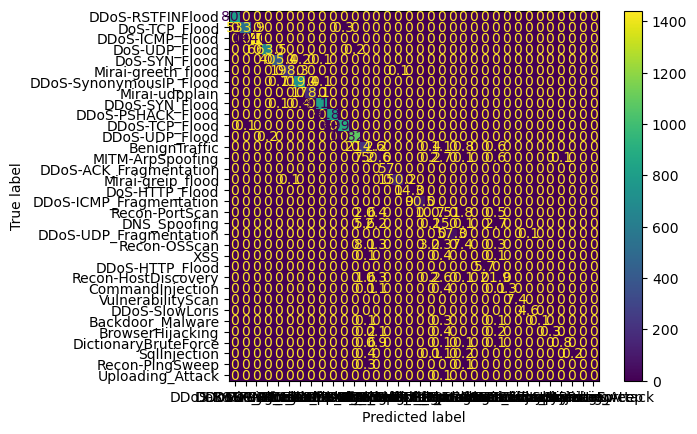

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 1d 15h 36min 48s, sys: 13min 1s, total: 1d 15h 49min 50s
Wall time: 51min 24s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9952314990731812),
                ('Precision (Macro)', 0.8874258335143487),
                ('Precision (Micro)', 0.9952314990731812),
                ('Precision (Weighted)', 0.9953776177522266),
                ('Recall (Macro)', 0.8751557549139894),
                ('Recall (Micro)', 0.9952314990731812),
                ('Recall (Weighted)', 0.9952314990731812),
                ('F1 (Macro)', 0.879851207581994),
                ('F1 (Micro)', 0.9952314990731812),
                ('F1 (Weighted)', 0.9952836700411499)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999989  0.999942  0.999965    809057
          DoS-TCP_Flood   0.999839  0.999439  0.999639    534289
        DDoS-ICMP_Flood   0.999985  0.999975  0.999980   1440101
          DoS-UDP_Flood   0.999757  0.999583  0.999670    663719
          DoS-SYN_Flood   0.999697  0.999293  0.999495    405767
     Mirai-greeth_flood   0.998286  0.998059  0.998172    198373
DDoS-SynonymousIP_Flood   0.999924  0.999843  0.999883    719628
         Mirai-udpplain   0.999848  0.999742  0.999795    178115
         DDoS-SYN_Flood   0.999649  0.999819  0.999734    811838
      DDoS-PSHACK_Flood   0.999998  0.999967  0.999982    818951
         DDoS-TCP_Flood   0.999653  0.999900  0.999777    899533
         DDoS-UDP_Flood   0.999747  0.999836  0.999792   1082457
          BenignTraffic   0.957379  0.939041  0.948121    219639
       MITM-ArpSpoofing   0.915686  0.871747  0.893177     61519
 DDoS-ACK_Fragmentation 

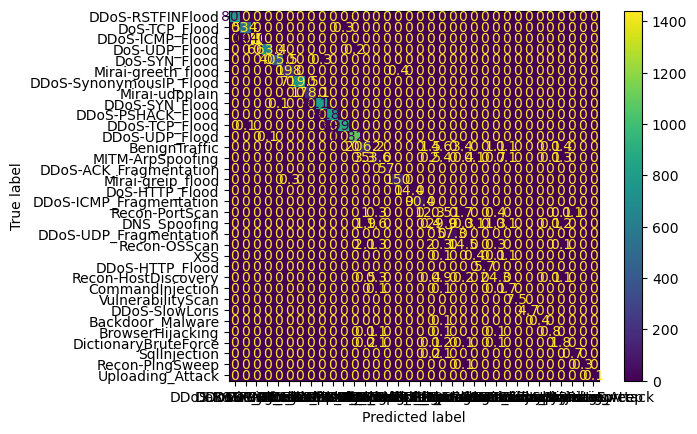

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)